## Implementing softmax regression for the CIFAR-10 dataset
In this assignment, you will implement a multi-class logistic regression, or softmax regression classifier, and apply it to a version of the CIFAR-10 object recognition dataset. This process involves writing vectorized versions of the softmax loss and gradient functions, choosing learning rates and regularization parameters for the optimization algorithm, and visualizing the learned coefficients of the model.

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython

%load_ext autoreload
%autoreload 2

## Load the CIFAR-10 dataset
Open up a terminal window and navigate to the **datasets** folder inside the  **hw3** folder. Run the
**get\_datasets.sh**  script. On my Mac, I just type in **./get\_datasets.sh** at the shell prompt.
A new folder called **cifar\_10\_batches\_py** will be created and it will contain $50000$ labeled
images for training and $10000$ labeled images for testing. The function further partitions the $50000$ training 
images into a train set and a validation set for selection of hyperparameters. We have provided a function to
read this data in **utils.py**. Each image is a $32 \times 32$ array of RGB triples. It is preprocessed by
subtracting the mean image from all images. We flatten each image into a 1-dimensional array of size
3072 (i.e., $32\times 32 \times 3$). Then a 1 is appended to the front of that vector to handle 
the intercept term.  So the training set is a numpy matrix of size $49000\times 3073$, 
the validation set is a matrix of size $1000\times 3073$ and the set-aside test set 
is of size $10000\times 3073$.

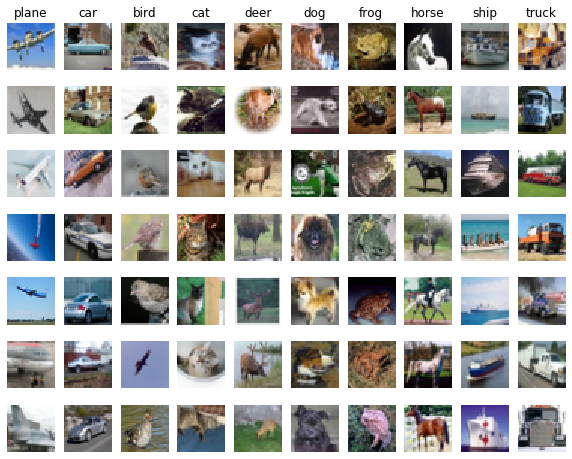

Training data shape: 49000,3072
Validation data shape: 1000,3072
Test data shape: 10000,3072
Training data shape with bias term: 49000,3073
Validation data shape with bias term: 1000,3073
Test data shape with bias term: 10000,3073


In [2]:
import utils

# Get the CIFAR-10 data broken up into train, validation and test sets

X_train, y_train, X_val, y_val, X_test, y_test = utils.get_CIFAR10_data()

## Implementing the loss function for softmax regression (naive version) 
Softmax regression generalizes logistic regression to classification problems where the class label $y$ can take on more than two possible values. This is useful for such problems as music genre classification and object recognition, where the goal is to distinguish between more than two different music genres or more than two different object categories.  Softmax regression is a supervised learning algorithm, but we will later be using it in conjunction with deep learning and unsupervised feature learning methods.
Recall that we are  given a data set 
$${\cal D} = \{(x^{(i)},y^{(i)}) | 1 \leq i \leq m; x^{(i)} \in \Re^{d+1}; {x_0}^{(i)} = 1, y^{(i)} \in \{1,\ldots, K\}\}, K>2 $$
Our probabilistic model $h_\theta(x)$ is defined as
\begin{eqnarray*}
 h_\theta(x) & = & 
 \left [ \begin{array}{l}
 P(y = 1|x; \theta) \\
 P(y = 2| x; \theta) \\
 \ldots \\
 P(y=K|x;\theta)
 \end{array} \right ]
 \end{eqnarray*}
 where 
 $$ P(y=k|x; \theta) = \frac{exp({\theta^{(k)}}^T x)} {\sum_{j=1}^{K} exp({\theta^{(j)}}^T x)} $$

The parameter  $\theta$ is a $(d+1)\times K$ matrix, where each column represents the parameter vector for class $k = 1,\ldots,K$.
$$\theta = \left [ \begin{array}{llll}
| & | & \ldots & | \\
| & | & \ldots & | \\
\theta^{(1)} & \theta^{(2)} & \ldots & \theta^{(K)} \\
|&  | & \ldots & | \\
| & | & \ldots  &| \\
\end{array}
\right ] $$

Numerical stability issues can come up in the computation of $P(y=k|x;\theta)$. Consider K=3, and $\theta^T x = [123, 456, 789]$. To compute $P(y=k|x;\theta)$ from these scores, we need to calculate $exp(123)$, $exp(456)$ and $exp(789)$, and sum them. These are very large numbers. However, we can get the same probabilities by subtracting the maximum ($789$) from  every element in $\theta^Tx$. Then we have the vector
$[-666,-333,0]$, and we can calculate $exp(-666)$, $exp(-333)$ and $exp(0)$, sum them (call the sum $S$) and then calculate $exp(-666)/S$, $exp(-333/S)$ and $exp(0)/S$.
 
The cost function $J(\theta)$ for softmax regression is derived from the negative log likelihood of the data ${\cal D}$, assuming that  $P(y|x;\theta) = h_\theta(x)$ as defined above.

$$J(\theta) = -\frac{1}{m}\sum_{i=1}^{m} \sum_{k=1}^{K} I\{y^{(i)} = k\} log \frac{exp({\theta^{(k)}}^T x^{(i)})}{\sum_{j=1}^{K} exp({\theta^{(j)}}^T x^{(i)})}  + \frac{\lambda}{2m} \sum_{j=0}^{d}\sum_{k=1}^{K} {{\theta_j}^{(k)}}^2 $$

where $I\{c\}$ is the indicator function which evaluates to 1 when $c$ is a true statement and to $0$ otherwise. The second term is a regularization term, where $\lambda$ is the regularization strength. While it is customary to exclude the bias term in L2 regularization, we include it here because it does not make a huge difference in the final result. You can check this for yourself on the CIFAR-10 dataset. You should implement this loss function using **for** loops for the summations in the function **softmax\_loss\_naive** in **softmax.py**. Once you have the loss function implemented, the cell below will run your loss function for a randomly initialized $\theta$ matrix with 49000 training images and labels with $\lambda$ set to 0. You should expect to see a value of about $-log_e(0.1)$ (Why?).

In [3]:
from softmax import softmax_loss_naive, softmax_loss_vectorized

# First implement the naive softmax loss function with nested loops.
# Open the file softmax.py and implement the
# softmax_loss_naive function.

# Generate a random softmax theta matrix and use it to compute the loss.

theta = np.random.randn(3073,10) * 0.0001
loss, grad = softmax_loss_naive(theta, X_train, y_train, 0.0)

# Loss should be something close to 2.32

print ('loss: (should be close to 2.32): ', loss)

loss: (should be close to 2.32):  2.3574235293605814


## Implementing the gradient of loss function for softmax regression (naive version) 
The derivative of the loss function $J(\theta)$ with respect to the $\theta^{(k)}$ is

$$ \nabla_{\theta^{(k)}} J(\theta) = - \frac{1}{m} \sum_{i=1}^{m} [x^{(i)} (1\{y^{(i)}=k\} - P(y^{(i)}=k|x^{(i)};\theta))] +\frac{\lambda}{m} \theta^{(k)}$$

Implement the analytical derivative computation in **softmax\_loss\_naive** in **softmax.py**.

We  check your implementation of the gradient using the method of finite differences. The functions in ** gradient\_check.py** compute the numerical gradient of a function $f$ as follows:
$$ \frac{\partial f(x)}{\partial x} = \frac{f(x+h)-f(x-h)}{2h} $$
for a very small $h$. The cell below will check your gradient against the numerically approximated gradient -- you should expect to see differences between the two gradients of the order of $10^{-7}$ or less. 


In [4]:
import time
# Open the file softmax.py and implement the gradient in the
# softmax_loss_naive function.

# Use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient. (within 1e-7)

from gradient_check import grad_check_sparse
f = lambda th: softmax_loss_naive(th, X_train, y_train, 0.0)[0]
grad_numerical = grad_check_sparse(f, theta, grad, 10)

tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(theta, X_train, y_train, 0.00001)
toc = time.time()
print('naive loss: %e computed in %f s' % (loss_naive, toc - tic))

numerical: -1.514482 analytic: -1.514482, relative error: 6.013432e-09
numerical: -1.387820 analytic: -1.387820, relative error: 8.155769e-09
numerical: -0.005840 analytic: -0.005840, relative error: 4.546665e-07
numerical: -2.311410 analytic: -2.311410, relative error: 2.873013e-08
numerical: 1.623735 analytic: 1.623735, relative error: 1.709621e-08
numerical: 4.470647 analytic: 4.470647, relative error: 1.021308e-08
numerical: 5.385077 analytic: 5.385077, relative error: 1.869404e-08
numerical: 2.549494 analytic: 2.549494, relative error: 3.349095e-08
numerical: -0.637163 analytic: -0.637163, relative error: 3.475906e-08
numerical: 0.276979 analytic: 0.276978, relative error: 1.206448e-07
naive loss: 2.357424e+00 computed in 8.799459 s


## Implementing the loss function and its gradient for softmax regression (vectorized version) 
Now complete the function **softmax\_loss\_vectorized** in **softmax.py** to implement the loss function $J(\theta)$ without using any **for** loops. Re-express the computation in terms of matrix operations on $X$, $y$ and $\theta$. 
Now vectorize the gradient computation in **softmax\_loss\_vectorized** in **softmax.py**. Once you complete this, the cell below will run and time your naive and vectorized implementations -- you should expect to see at least one order of magnitude difference in run time between the two implementations. 

In [5]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
from softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(theta, X_train, y_train, 0.00001)
toc = time.time()
print('vectorized loss: %e computed in %f s' % (loss_vectorized, toc - tic))

# We use the Frobenius norm to compare the two versions
# of the gradient.

grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

vectorized loss: 2.357424e+00 computed in 0.525594 s
Loss difference: 0.000000
Gradient difference: 0.000000


## Implementing mini-batch gradient descent 
In large-scale applications, the training data can have millions of examples. Hence, it seems wasteful to compute the  loss function over the entire training set in order to perform only a single parameter update. A very common approach to addressing this challenge is to compute the gradient over batches of the training data. For example, a typical batch contains 256 examples from a training set of over 1.2 million. This batch is then used to perform a parameter update:
$$ \theta^{(k)} \to \theta^{(k)} - \alpha \nabla_{\theta^{(k)}} J(\theta) $$
where $\alpha$ is the step size or learning rate for gradient descent.

Implement mini-batch gradient descent in the method **train** in **linear_classifier.py** using the description provided in the documentation of the method. You can set the **verbose** argument of **train** to be **True** and observe how the loss function varies with iteration number.

You will test your implementation of mini-batch gradient descent in the search for hyperparameters below.

## Using a validation set to select regularization lambda and learning rate for   gradient descent
There are many hyper parameters to be selected for mini batch gradient descent -- the batch size, the number of iterations, and the learning rate. For the loss function, we also need to select $\lambda$, the regularization strength. In this exercise, we have pre-selected a batch size of 400 and an iteration count of 4000. Now, use the validation set provided to sweep the learning rate and the $\lambda$ parameter space, using the suggested values in the cell below to find the best combination of these two hyper parameters. Fill in the code to do this in the section marked **TODO** below.

Once you find the best values of $\lambda$ and learning rate, insert code in the cell below to train a softmax classifier on the training data with the best hyper parameters and save this classifier in the variable  **best\_softmax**.  

In [6]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set and the test set.

import linear_classifier

results = {}
best_val = -1
best_softmax = None
learning_rates = [1e-7, 5e-7, 1e-6, 5e-6]
regularization_strengths = [5e4, 1e5, 5e5, 1e8]
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# Save the best trained softmax classifer in variable best_softmax.            #
################################################################################
model = linear_classifier.Softmax()
for l in learning_rates:
    for reg in regularization_strengths:
        model.train(X_train, y_train, learning_rate=l, reg=reg, num_iters=600, batch_size=400, verbose=True)
        train_accuracy = np.mean(model.predict(X_train) == y_train)
        val_accuracy = np.mean(model.predict(X_val) == y_val)
        results[l, reg] = {train_accuracy, val_accuracy}
# model.train(X_train, y_train, learning_rate=5e-6, reg=1e8, num_iters=4000, batch_size=400, verbose=True)
# train_accuracy = np.mean(model.predict(X_train) == y_train)
# val_accuracy = np.mean(model.predict(X_val) == y_val)
# results[l, reg] = {train_accuracy, val_accuracy}
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    best_val = max(best_val, val_accuracy)
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 600: loss 8.511588
iteration 100 / 600: loss 6.389098
iteration 200 / 600: loss 5.715551
iteration 300 / 600: loss 5.450997
iteration 400 / 600: loss 5.381669
iteration 500 / 600: loss 5.077904
iteration 0 / 600: loss 6.783522
iteration 100 / 600: loss 6.752401
iteration 200 / 600: loss 6.883067
iteration 300 / 600: loss 6.439292
iteration 400 / 600: loss 6.550990
iteration 500 / 600: loss 6.385256
iteration 0 / 600: loss 20.889673
iteration 100 / 600: loss 20.326605
iteration 200 / 600: loss 19.883778
iteration 300 / 600: loss 19.311335
iteration 400 / 600: loss 18.733504
iteration 500 / 600: loss 18.210066
iteration 0 / 600: loss 3107.344694
iteration 100 / 600: loss 21.790913
iteration 200 / 600: loss 2.340277
iteration 300 / 600: loss 2.192751
iteration 400 / 600: loss 2.194928
iteration 500 / 600: loss 2.222631
iteration 0 / 600: loss 2.143513
iteration 100 / 600: loss 1.863568
iteration 200 / 600: loss 1.857106
iteration 300 / 600: loss 1.835461
iteration 400 / 600:

In [7]:
# lr 5.000000e-07 reg 5.000000e+05 train accuracy: 0.413449 val accuracy: 0.415000
# best validation accuracy achieved during cross-validation: 0.415000

# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set and the test set.

import linear_classifier

results = {}
best_val = -1
best_softmax = None
################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# Save the best trained softmax classifer in variable best_softmax.            #
################################################################################
model.train(X_train, y_train, learning_rate=5e-7, reg=5e5, num_iters=4000, batch_size=400, verbose=True)
train_accuracy = np.mean(model.predict(X_train) == y_train)
val_accuracy = np.mean(model.predict(X_val) == y_val)
################################################################################
#                              END OF YOUR CODE                                #
################################################################################

# Print out results.
print(f'for learning rate = 5e-7 and regularization term = 5e+5, train_accuracy is{train_accuracy}, validation accuracy is {val_accuracy}')

iteration 0 / 4000: loss 7.178092
iteration 100 / 4000: loss 1.882310
iteration 200 / 4000: loss 1.864011
iteration 300 / 4000: loss 1.855977
iteration 400 / 4000: loss 1.843837
iteration 500 / 4000: loss 1.790357
iteration 600 / 4000: loss 1.869056
iteration 700 / 4000: loss 1.779268
iteration 800 / 4000: loss 1.890653
iteration 900 / 4000: loss 1.878375
iteration 1000 / 4000: loss 1.808106
iteration 1100 / 4000: loss 1.722473
iteration 1200 / 4000: loss 1.859147
iteration 1300 / 4000: loss 1.736832
iteration 1400 / 4000: loss 1.870415
iteration 1500 / 4000: loss 1.799600
iteration 1600 / 4000: loss 1.827542
iteration 1700 / 4000: loss 1.834916
iteration 1800 / 4000: loss 1.819046
iteration 1900 / 4000: loss 1.726590
iteration 2000 / 4000: loss 1.772339
iteration 2100 / 4000: loss 1.795937
iteration 2200 / 4000: loss 1.730110
iteration 2300 / 4000: loss 1.771713
iteration 2400 / 4000: loss 1.765284
iteration 2500 / 4000: loss 1.787071
iteration 2600 / 4000: loss 1.790343
iteration 270

## Evaluating the best softmax classifier on the test set and visualizing the coefficients
The best\_softmax classifier will be  evaluated on the set aside test set and you should expect to see an overall accuracy of over 35%. 

Compute the confusion matrix (you can use the confusion\_matrix function in **sklearn.metrics** on the test set for your predictor and interpret the visualized coefficients in the light of the errors made by the classifier.

We can remove the bias term from the $\theta$ matrix and reshape each column of the matrix which is a parameter vector of size $3072$ back into an array of size $32\times 32 \times 3$ and visualize the results as an image. The cell below  constructs such a plot, similar to the one in Figure 2 in hw3.pdf. 

In [8]:
best_softmax = linear_classifier.Softmax()
best_softmax.train(X_train, y_train, learning_rate= 5e-7, reg= 5e5, num_iters=4000, batch_size=400, verbose=False)

[24.10636093771738,
 24.4244165900985,
 23.81872283387656,
 23.899567257574702,
 24.032522435384102,
 23.781567958692,
 23.512846834363,
 23.566715521246046,
 23.381258261783486,
 23.40228908002751,
 23.021976705591097,
 23.06386832517678,
 23.010464394367585,
 23.175859222033804,
 22.862154251056623,
 22.554779981724266,
 22.687956955514448,
 22.5047675305612,
 22.567404378994055,
 22.310247411796123,
 22.250654391275333,
 22.482252439868834,
 22.572640847446884,
 22.06384473915793,
 22.17773122806078,
 22.312249349514396,
 22.199388797630405,
 21.819589505190976,
 22.00472690630368,
 22.080948550878567,
 21.98510745045368,
 21.838086969996567,
 21.839950442126646,
 21.843476791878864,
 21.995696444423196,
 21.80825746456603,
 21.50204901147277,
 21.386569046549397,
 21.65767478834198,
 21.493042921823474,
 21.326956054723617,
 21.398252569202292,
 21.36019359395833,
 21.414702623386244,
 21.337177709303734,
 21.35672370393774,
 21.24926028625952,
 21.34106990877798,
 20.9844103869272

softmax on raw pixels final test set accuracy: 0.399500
[[487  53  37  31  15  20  30  38 214  75]
 [ 57 497  21  27  16  41  55  36  94 156]
 [113  52 207  77 114  83 208  60  60  26]
 [ 46  73  80 207  48 190 181  54  54  67]
 [ 67  38 112  43 277  85 219  95  37  27]
 [ 44  41  83 129  69 348 119  66  71  30]
 [ 21  53  58  84  70  70 550  27  25  42]
 [ 54  51  60  44  96  72  75 396  53  99]
 [143  81   8  21   5  52  13  14 553 110]
 [ 66 187  12  26  13  20  51  39 113 473]]


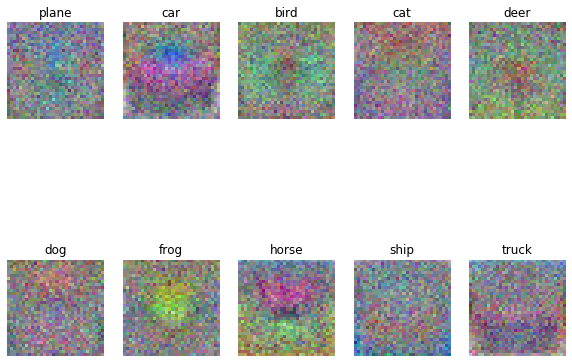

In [9]:
# Evaluate the best softmax classifier on test set

y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

# compute confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_test_pred))

# Visualize the learned weights for each class`

theta = best_softmax.theta[1:,:].T # strip out the bias term
theta = theta.reshape(10, 32, 32, 3)

theta_min, theta_max = np.min(theta), np.max(theta)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  thetaimg = 255.0 * (theta[i].squeeze() - theta_min) / (theta_max - theta_min)
  plt.imshow(thetaimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])
plt.savefig('vis77.png')
plt.show()

## Extra credit:  Experimenting with other hyper parameters and optimization method
We chose a batch size of 400 and 4000 iterations for our previous experiments. Explore larger and smaller batch sizes, choosing an appropriate number of iterations (by specifying a tolerance on differences in values of the loss function or its gradient in successive iterations) with the validation set. Produce plots that show the variation of test set accuracy as a function of batch size/number of iterations. You will have to determine the right settings for regularization strength $\lambda$ and learning rate for each batch size/number of iterations combination. What is the best batch size/number of iterations/learning rate/regularization strength combination for this problem? What is the best test set accuracy that can be achieved by this combination? 

In [10]:
import linear_classifier
import pandas as pd

df_batch = pd.DataFrame()
df_iter = pd.DataFrame()
model = linear_classifier.Softmax()
results = {}
best_val = -1
best_softmax = None
batch_sizes = [i for i in range(200, 2000, 300)]
iter_numbers = [i for i in range(1000, 5000, 1000)]
for it in iter_numbers:
    df_iter[f'{it}'] = pd.Series(0)
for batch in batch_sizes:
    df_batch[f'{batch}'] = pd.Series(0)

for batch in batch_sizes:
    best = 0
    for it in iter_numbers:
        model.train(X_train, y_train, learning_rate=5e-7, reg=5e5, num_iters=it, batch_size=batch, verbose=True)
        train_accuracy = np.mean(model.predict(X_train) == y_train)
        val_accuracy = np.mean(model.predict(X_val) == y_val)
        test_accuracy = np.mean(model.predict(X_test) == y_test)
        df_iter[f'{it}'] = pd.Series(max(df_iter[f'{it}'].item(), test_accuracy))
        results[batch, it] = {train_accuracy, val_accuracy}
        best = max(test_accuracy, best)
    df_batch[f'{batch}'] = pd.Series(max(df_batch[f'{batch}'].item(), best))
for batch, it in sorted(results):
    train_accuracy, val_accuracy = results[(batch, it)]
    print('batch %e iteration %e train accuracy: %f val accuracy: %f' % (
                batch, it, train_accuracy, val_accuracy))
    best_val = max(best_val, val_accuracy)
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 1000: loss 44.562352
iteration 100 / 1000: loss 32.068010
iteration 200 / 1000: loss 24.939557
iteration 300 / 1000: loss 19.777443
iteration 400 / 1000: loss 15.690084
iteration 500 / 1000: loss 12.613391
iteration 600 / 1000: loss 10.145415
iteration 700 / 1000: loss 8.460206
iteration 800 / 1000: loss 6.776206
iteration 900 / 1000: loss 5.682475
iteration 0 / 2000: loss 4.878563
iteration 100 / 2000: loss 4.127626
iteration 200 / 2000: loss 3.625205
iteration 300 / 2000: loss 3.234718
iteration 400 / 2000: loss 2.853445
iteration 500 / 2000: loss 2.549417
iteration 600 / 2000: loss 2.394552
iteration 700 / 2000: loss 2.325951
iteration 800 / 2000: loss 2.225623
iteration 900 / 2000: loss 2.073156
iteration 1000 / 2000: loss 2.120273
iteration 1100 / 2000: loss 2.100873
iteration 1200 / 2000: loss 2.061752
iteration 1300 / 2000: loss 1.851497
iteration 1400 / 2000: loss 1.841530
iteration 1500 / 2000: loss 1.880104
iteration 1600 / 2000: loss 1.960821
iteration 1700 / 2

iteration 1500 / 2000: loss 1.736536
iteration 1600 / 2000: loss 1.819829
iteration 1700 / 2000: loss 1.789790
iteration 1800 / 2000: loss 1.780163
iteration 1900 / 2000: loss 1.789641
iteration 0 / 3000: loss 1.791776
iteration 100 / 3000: loss 1.770292
iteration 200 / 3000: loss 1.717682
iteration 300 / 3000: loss 1.785536
iteration 400 / 3000: loss 1.800241
iteration 500 / 3000: loss 1.713586
iteration 600 / 3000: loss 1.737859
iteration 700 / 3000: loss 1.723578
iteration 800 / 3000: loss 1.800407
iteration 900 / 3000: loss 1.782262
iteration 1000 / 3000: loss 1.792423
iteration 1100 / 3000: loss 1.742294
iteration 1200 / 3000: loss 1.735678
iteration 1300 / 3000: loss 1.742155
iteration 1400 / 3000: loss 1.723922
iteration 1500 / 3000: loss 1.772163
iteration 1600 / 3000: loss 1.715409
iteration 1700 / 3000: loss 1.750229
iteration 1800 / 3000: loss 1.753681
iteration 1900 / 3000: loss 1.772766
iteration 2000 / 3000: loss 1.761854
iteration 2100 / 3000: loss 1.775471
iteration 220

iteration 2000 / 3000: loss 1.696780
iteration 2100 / 3000: loss 1.761740
iteration 2200 / 3000: loss 1.691681
iteration 2300 / 3000: loss 1.768781
iteration 2400 / 3000: loss 1.654857
iteration 2500 / 3000: loss 1.707566
iteration 2600 / 3000: loss 1.747905
iteration 2700 / 3000: loss 1.733588
iteration 2800 / 3000: loss 1.758860
iteration 2900 / 3000: loss 1.705168
iteration 0 / 4000: loss 1.765638
iteration 100 / 4000: loss 1.720161
iteration 200 / 4000: loss 1.768562
iteration 300 / 4000: loss 1.731458
iteration 400 / 4000: loss 1.699886
iteration 500 / 4000: loss 1.710969
iteration 600 / 4000: loss 1.727460
iteration 700 / 4000: loss 1.741413
iteration 800 / 4000: loss 1.722064
iteration 900 / 4000: loss 1.705154
iteration 1000 / 4000: loss 1.732041
iteration 1100 / 4000: loss 1.763061
iteration 1200 / 4000: loss 1.702225
iteration 1300 / 4000: loss 1.728007
iteration 1400 / 4000: loss 1.735379
iteration 1500 / 4000: loss 1.702009
iteration 1600 / 4000: loss 1.699726
iteration 170

In [11]:
# lr 2.000000e+02 reg 1.000000e+03 train accuracy: 0.370898 val accuracy: 0.363000
# lr 2.000000e+02 reg 2.000000e+03 train accuracy: 0.402592 val accuracy: 0.405000
# lr 2.000000e+02 reg 3.000000e+03 train accuracy: 0.402673 val accuracy: 0.405000
# lr 2.000000e+02 reg 4.000000e+03 train accuracy: 0.403122 val accuracy: 0.407000
# lr 5.000000e+02 reg 1.000000e+03 train accuracy: 0.413959 val accuracy: 0.402000
# lr 5.000000e+02 reg 2.000000e+03 train accuracy: 0.417837 val accuracy: 0.411000
# lr 5.000000e+02 reg 3.000000e+03 train accuracy: 0.418020 val accuracy: 0.412000
# lr 5.000000e+02 reg 4.000000e+03 train accuracy: 0.418837 val accuracy: 0.407000
# lr 8.000000e+02 reg 1.000000e+03 train accuracy: 0.421245 val accuracy: 0.405000
# lr 8.000000e+02 reg 2.000000e+03 train accuracy: 0.421776 val accuracy: 0.406000
# lr 8.000000e+02 reg 3.000000e+03 train accuracy: 0.424510 val accuracy: 0.417000
# lr 8.000000e+02 reg 4.000000e+03 train accuracy: 0.426653 val accuracy: 0.421000
# lr 1.100000e+03 reg 1.000000e+03 train accuracy: 0.426837 val accuracy: 0.403000
# lr 1.100000e+03 reg 2.000000e+03 train accuracy: 0.429082 val accuracy: 0.411000
# lr 1.100000e+03 reg 3.000000e+03 train accuracy: 0.429143 val accuracy: 0.416000
# lr 1.100000e+03 reg 4.000000e+03 train accuracy: 0.430286 val accuracy: 0.416000
# lr 1.400000e+03 reg 1.000000e+03 train accuracy: 0.432510 val accuracy: 0.412000
# lr 1.400000e+03 reg 2.000000e+03 train accuracy: 0.432939 val accuracy: 0.414000
# lr 1.400000e+03 reg 3.000000e+03 train accuracy: 0.434429 val accuracy: 0.417000
# lr 1.400000e+03 reg 4.000000e+03 train accuracy: 0.434633 val accuracy: 0.420000
# lr 1.700000e+03 reg 1.000000e+03 train accuracy: 0.434143 val accuracy: 0.414000
# lr 1.700000e+03 reg 2.000000e+03 train accuracy: 0.436612 val accuracy: 0.427000
# lr 1.700000e+03 reg 3.000000e+03 train accuracy: 0.437510 val accuracy: 0.412000
# lr 1.700000e+03 reg 4.000000e+03 train accuracy: 0.437286 val accuracy: 0.418000
# best validation accuracy achieved during cross-validation: 0.427000
df_batch.to_csv('batch.csv')
df_iter.to_csv('iter.csv')

In [12]:
import pandas as pd
df_batch = pd.read_csv('batch.csv')
df_iter = pd.read_csv('iter.csv')

In [13]:
df_batch

,Unnamed: 0,200,500,800,1100,1400,1700
0,0,0.3955,0.4064,0.4092,0.412,0.4129,0.4136


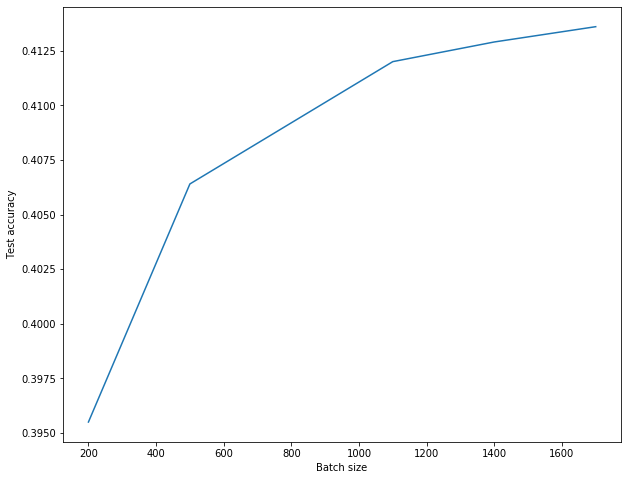

In [14]:
import matplotlib.pyplot as plt
x = [200, 500, 800, 1100, 1400, 1700]
y = df_batch.loc[0][1:]
plt.plot(x, y)
plt.xlabel('Batch size')
plt.ylabel('Test accuracy')
plt.savefig('batch.png')
plt.show()

In [15]:
df_iter

,Unnamed: 0,1000,2000,3000,4000
0,0,0.413,0.4136,0.4125,0.4129


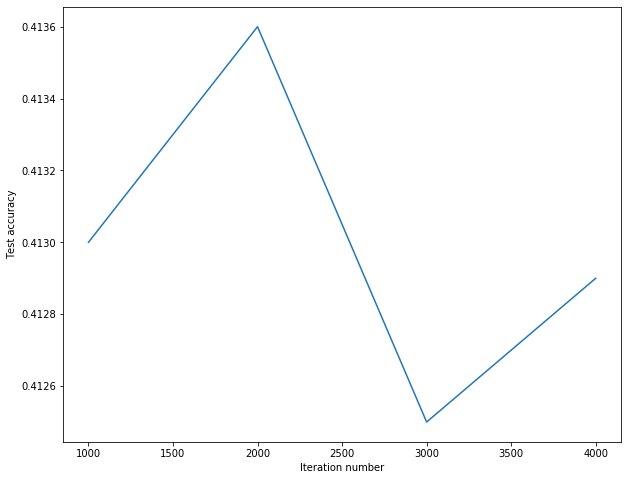

In [16]:
x = [1000, 2000, 3000, 4000]
y = df_iter.loc[0][1:]
plt.plot(x, y)
plt.xlabel('Iteration number')
plt.ylabel('Test accuracy')
plt.savefig('iter.png')
plt.show()

In [17]:
best_softmax = linear_classifier.Softmax()
best_softmax.train(X_train, y_train, learning_rate= 5e-7, reg= 5e5, num_iters=1700, batch_size=2000, verbose=False)

[9.032327077260655,
 9.019012437253835,
 8.929782656995393,
 8.887604474088029,
 8.66991784486896,
 8.547080280173633,
 8.394778624018667,
 8.429736100072633,
 8.434199356435357,
 8.380791396440285,
 8.336665892142513,
 8.319269987108427,
 8.200085963173297,
 8.102901049512141,
 8.1733022180687,
 8.045231015667952,
 7.99619539163877,
 7.889516645397648,
 7.819736022233897,
 8.007746264911914,
 7.741586817440467,
 7.846736825100601,
 7.83536134340466,
 7.641751611904631,
 7.751539136627679,
 7.636591926413719,
 7.6947834203421674,
 7.5784032982644565,
 7.63437830772153,
 7.587366829189956,
 7.544053132542258,
 7.61534311968748,
 7.64644190846316,
 7.565699032920168,
 7.435546341603098,
 7.445652192113084,
 7.377049473286924,
 7.3994129693268444,
 7.387522924738279,
 7.4693493974066225,
 7.452409701098017,
 7.44365647905993,
 7.291509191541584,
 7.368955047143056,
 7.303483892736623,
 7.36633560283195,
 7.3296430844927025,
 7.215040903619842,
 7.260596404233002,
 7.293663620357792,
 7.23

softmax on raw pixels final test set accuracy: 0.331600
[[415  47  60  42  23  41  23  48 222  79]
 [ 73 396  32  51  33  47  46  42 119 161]
 [106  56 176  85 161  92 131  74  77  42]
 [ 59  77  78 226  62 175 116  58  74  75]
 [ 60  32 136  82 246  88 172 111  33  40]
 [ 57  51  92 164  84 268 103  76  70  35]
 [ 19  46  82 138 119  86 374  54  36  46]
 [ 73  49  60  61 125  91  63 318  64  96]
 [169  90  15  30  12  46  16  19 489 114]
 [ 70 212  25  35  23  18  48  46 115 408]]


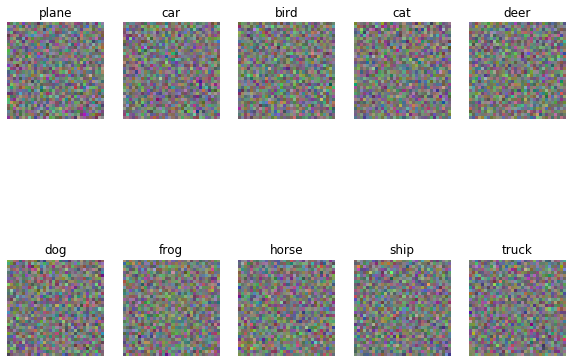

In [18]:
# Evaluate the best softmax classifier on test set

y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

# compute confusion matrix
from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test,y_test_pred))

# Visualize the learned weights for each class`

theta = best_softmax.theta[1:,:].T # strip out the bias term
theta = theta.reshape(10, 32, 32, 3)

theta_min, theta_max = np.min(theta), np.max(theta)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)
  
  # Rescale the weights to be between 0 and 255
  thetaimg = 255.0 * (theta[i].squeeze() - theta_min) / (theta_max - theta_min)
  plt.imshow(thetaimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])
plt.savefig('vis88.png')
plt.show()